# ARC-AGI Task Visualization

This notebook visualizes ARC-AGI puzzles from training dataset JSON files. It displays input-output pairs in a clear format to help understand the dataset structure and patterns.

## Features:
- Load any ARC training JSON file by path
- Visualize all training pairs in 2-column format (Input | Output)
- Handle variable number of puzzles per file
- Compatible with Google Colab

In [2]:
# Setup for Google Colab
!git clone https://github.com/CalebTalley2024/ARC-AGI-2.git
%cd ARC-AGI-2

!git checkout vedant

# Install exact package versions for reproducibility
!pip install --quiet \
    numpy==1.24.4 \
    matplotlib==3.7.5 \
    pandas==2.0.3 \
    scipy==1.10.1 \
    scikit-learn==1.3.2 \
    torch==2.2.2 \
    torchvision==0.17.2 \
    torchaudio==2.2.2 \
    transformers==4.46.3 \
    huggingface-hub==0.36.0 \
    seaborn==0.13.2 \
    plotly==6.4.0 \
    tqdm==4.67.1 \
    pyyaml==6.0.3 \
    requests==2.32.4 \
    packaging==25.0 \
    jsonschema==4.23.0 \
    fastjsonschema==2.21.2 \
    jinja2==3.1.6 \
    markupsafe==2.1.5 \
    urllib3==2.2.3 \
    certifi==2025.10.5 \
    charset-normalizer==3.4.4 \
    idna==3.11 \
    python-dateutil==2.9.0.post0 \
    pytz==2025.2 \
    tzdata==2025.2 \
    six==1.17.0 \
    setuptools==75.3.2

# Install the package in development mode
!pip install -e .

Cloning into 'ARC-AGI-2'...
remote: Enumerating objects: 1674, done.
remote: Counting objects: 100% (569/569), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 1674 (delta 484), reused 479 (delta 440), pack-reused 1105 (from 1)
Receiving objects: 100% (1674/1674), 1.22 MiB | 15.60 MiB/s, done.
Resolving deltas: 100% (899/899), done.
/content/ARC-AGI-2
Branch 'vedant' set up to track remote branch 'vedant' from 'origin'.
Switched to a new branch 'vedant'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 50.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit 

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os

# Color map for visualization (0-9 colors for ARC grids)
COLOR_MAP = [
    '#000000',  # 0: black
    '#0074D9',  # 1: blue
    '#FF4136',  # 2: red
    '#2ECC40',  # 3: green
    '#FFDC00',  # 4: yellow
    '#AAAAAA',  # 5: grey
    '#F012BE',  # 6: magenta
    '#FF851B',  # 7: orange
    '#7FDBFF',  # 8: sky blue
    '#870C25'   # 9: brown
]

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [4]:
def load_arc_data(txt_file_path):
    """
    Load ARC training or evaluation data from txt file containing task IDs

    Args:
        txt_file_path: Path to .txt file containing list of task IDs

    Returns:
        Dictionary with task_id as keys and task data as values
    """
    try:
        # Read the txt file to get task IDs
        with open(txt_file_path, 'r') as f:
            task_ids = [line.strip() for line in f if line.strip()]

        # Determine the JSON directory based on txt file name
        txt_path = Path(txt_file_path)
        base_dir = txt_path.parent

        if 'training' in txt_path.name:
            json_dir = base_dir / 'training'
        elif 'evaluation' in txt_path.name:
            json_dir = base_dir / 'evaluation'
        else:
            print(f"Unknown data type from file name: {txt_path.name}")
            return None

        if not json_dir.exists():
            print(f"JSON directory not found: {json_dir}")
            return None

        # Load all JSON files for the task IDs
        data = {}
        loaded_count = 0
        missing_files = []

        for task_id in task_ids:
            json_file = json_dir / f"{task_id}.json"

            if json_file.exists():
                try:
                    with open(json_file, 'r') as f:
                        task_data = json.load(f)
                    data[task_id] = task_data
                    loaded_count += 1
                except json.JSONDecodeError as e:
                    print(f"Error parsing JSON file {json_file}: {e}")
            else:
                missing_files.append(task_id)

        print(f"Loaded {loaded_count} tasks from {txt_file_path}")
        print(f"JSON files source: {json_dir}")

        if missing_files:
            print(f"Missing JSON files for {len(missing_files)} task IDs:")
            for task_id in missing_files[:5]:  # Show first 5 missing
                print(f"   {task_id}.json")
            if len(missing_files) > 5:
                print(f"   ... and {len(missing_files) - 5} more")

        return data

    except FileNotFoundError:
        print(f"Data file not found: {txt_file_path}")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def load_random_tasks(txt_file_path, num_tasks=3):
    """
    Load random subset of tasks from txt file containing task IDs

    Args:
        txt_file_path: Path to .txt file containing list of task IDs
        num_tasks: Number of random tasks to load

    Returns:
        Dictionary with task_id as keys and task data as values
    """
    try:
        # Read the txt file to get task IDs
        with open(txt_file_path, 'r') as f:
            all_task_ids = [line.strip() for line in f if line.strip()]

        # Randomly select subset of task IDs
        import random
        if len(all_task_ids) <= num_tasks:
            selected_task_ids = all_task_ids
            print(f"Selected all {len(all_task_ids)} available tasks")
        else:
            selected_task_ids = random.sample(all_task_ids, num_tasks)
            print(f"Randomly selected {num_tasks} tasks from {len(all_task_ids)} available")

        # Determine the JSON directory based on txt file name
        txt_path = Path(txt_file_path)
        base_dir = txt_path.parent

        if 'training' in txt_path.name:
            json_dir = base_dir / 'training'
        elif 'evaluation' in txt_path.name:
            json_dir = base_dir / 'evaluation'
        else:
            print(f"Unknown data type from file name: {txt_path.name}")
            return None

        if not json_dir.exists():
            print(f"JSON directory not found: {json_dir}")
            return None

        # Load JSON files for selected task IDs
        data = {}
        loaded_count = 0
        missing_files = []

        for task_id in selected_task_ids:
            json_file = json_dir / f"{task_id}.json"

            if json_file.exists():
                try:
                    with open(json_file, 'r') as f:
                        task_data = json.load(f)
                    data[task_id] = task_data
                    loaded_count += 1
                except json.JSONDecodeError as e:
                    print(f"Error parsing JSON file {json_file}: {e}")
            else:
                missing_files.append(task_id)

        print(f"Successfully loaded {loaded_count} JSON files")
        if missing_files:
            print(f"Missing JSON files: {missing_files}")

        return data

    except FileNotFoundError:
        print(f"Data file not found: {txt_file_path}")
        return None
    except Exception as e:
        print(f"Error loading random tasks: {e}")
        return None

def plot_grid(grid, title="", ax=None):
    """Plot a single ARC grid with proper colors"""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    grid_array = np.array(grid)
    height, width = grid_array.shape

    # Create color mapping
    colored_grid = np.zeros((height, width, 3))
    for i in range(height):
        for j in range(width):
            color_hex = COLOR_MAP[grid_array[i, j]]
            # Convert hex to RGB
            r = int(color_hex[1:3], 16) / 255.0
            g = int(color_hex[3:5], 16) / 255.0
            b = int(color_hex[5:7], 16) / 255.0
            colored_grid[i, j] = [r, g, b]

    ax.imshow(colored_grid, interpolation='nearest')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])

    # Add grid lines
    for i in range(height + 1):
        ax.axhline(i - 0.5, color='white', linewidth=1)
    for j in range(width + 1):
        ax.axvline(j - 0.5, color='white', linewidth=1)

    return ax

print("Data loading functions defined!")
print("Usage:")
print("  load_arc_data('data/raw/arc/training.txt') - Load all training tasks")
print("  load_arc_data('data/raw/arc/evaluation.txt') - Load all evaluation tasks")
print("  load_random_tasks('data/raw/arc/training.txt', 10) - Load 10 random training tasks")

Data loading functions defined!
Usage:
  load_arc_data('data/raw/arc/training.txt') - Load all training tasks
  load_arc_data('data/raw/arc/evaluation.txt') - Load all evaluation tasks
  load_random_tasks('data/raw/arc/training.txt', 10) - Load 10 random training tasks


In [5]:
def visualize_task_pairs(task_data, task_id, max_pairs=3):
    """Visualize input/output pairs for a specific task in 2-column format"""
    if task_id not in task_data:
        print(f"Task {task_id} not found in data")
        return

    task = task_data[task_id]
    train_pairs = task['train']
    test_pairs = task['test']

    num_train = min(len(train_pairs), max_pairs)
    num_test = min(len(test_pairs), max_pairs)
    total_pairs = num_train + num_test

    if total_pairs == 0:
        print("No pairs to visualize")
        return

    # Create subplot grid: 2 columns (Input | Output), rows for each pair
    fig, axes = plt.subplots(total_pairs, 2, figsize=(12, 4*total_pairs))

    # Handle single row case
    if total_pairs == 1:
        axes = axes.reshape(1, -1)

    # Plot training pairs
    for i in range(num_train):
        pair = train_pairs[i]
        input_grid = pair['input']
        output_grid = pair['output']

        plot_grid(input_grid, f"Train {i+1} - Input", axes[i, 0])
        plot_grid(output_grid, f"Train {i+1} - Output", axes[i, 1])

    # Plot test pairs
    for i in range(num_test):
        pair = test_pairs[i]
        input_grid = pair['input']
        output_grid = pair['output']

        row_idx = num_train + i
        plot_grid(input_grid, f"Test {i+1} - Input", axes[row_idx, 0])
        plot_grid(output_grid, f"Test {i+1} - Output", axes[row_idx, 1])

    plt.suptitle(f"ARC Task: {task_id}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def browse_tasks(data, start_idx=0, num_tasks=5):
    """Browse through multiple tasks with their IDs"""
    task_ids = list(data.keys())
    end_idx = min(start_idx + num_tasks, len(task_ids))

    print(f"Showing tasks {start_idx+1} to {end_idx} of {len(task_ids)} total tasks:")
    print("-" * 50)

    for i in range(start_idx, end_idx):
        task_id = task_ids[i]
        task = data[task_id]
        num_train = len(task['train'])
        num_test = len(task['test'])
        print(f"{i+1:3d}. Task ID: {task_id} | Train: {num_train} | Test: {num_test}")

    print("-" * 50)
    print(f"To visualize a task, use: visualize_task_pairs(data, 'task_id')")

print("Task visualization functions defined!")

Task visualization functions defined!


In [6]:
import random

def visualize_task_from_data(data, task_id, max_pairs=3):
    """Visualize input/output pairs for a specific task from loaded data"""
    if not data or task_id not in data:
        print(f"Task {task_id} not found in provided data")
        return

    task = data[task_id]
    train_pairs = task['train']
    test_pairs = task['test']

    num_train = min(len(train_pairs), max_pairs)
    num_test = min(len(test_pairs), max_pairs)
    total_pairs = num_train + num_test

    if total_pairs == 0:
        print("No pairs to visualize")
        return

    # Create subplot grid: 2 columns (Input | Output), rows for each pair
    fig, axes = plt.subplots(total_pairs, 2, figsize=(12, 4*total_pairs))

    # Handle single row case
    if total_pairs == 1:
        axes = axes.reshape(1, -1)

    # Plot training pairs
    for i in range(num_train):
        pair = train_pairs[i]
        input_grid = pair['input']
        output_grid = pair['output']

        plot_grid(input_grid, f"Train {i+1} - Input", axes[i, 0])
        plot_grid(output_grid, f"Train {i+1} - Output", axes[i, 1])

    # Plot test pairs
    for i in range(num_test):
        pair = test_pairs[i]
        input_grid = pair['input']
        output_grid = pair['output']

        row_idx = num_train + i
        plot_grid(input_grid, f"Test {i+1} - Input", axes[row_idx, 0])
        plot_grid(output_grid, f"Test {i+1} - Output", axes[row_idx, 1])

    plt.suptitle(f"ARC Task: {task_id}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def visualize_all_tasks_in_data(data, show_all_pairs=True, max_pairs=3):
    """
    Visualize all tasks in the provided data dictionary

    Args:
        data: Dictionary of ARC tasks (from load_arc_data or load_random_tasks)
        show_all_pairs: If True, shows all pairs; if False, limits pairs per task
        max_pairs: Maximum pairs to show per task when show_all_pairs=False
    """
    if not data:
        print("No data provided")
        return

    task_ids = list(data.keys())
    print(f"Visualizing {len(task_ids)} tasks:")
    print("=" * 60)

    for idx, task_id in enumerate(task_ids, 1):
        task = data[task_id]
        train_pairs = task['train']
        test_pairs = task['test']

        print(f"\n{idx}. Task ID: {task_id}")
        print(f"   Training pairs: {len(train_pairs)}")
        print(f"   Test pairs: {len(test_pairs)}")
        print("-" * 40)

        # Calculate total pairs to show
        if show_all_pairs:
            num_train = len(train_pairs)
            num_test = len(test_pairs)
        else:
            num_train = min(len(train_pairs), max_pairs)
            num_test = min(len(test_pairs), max_pairs)

        total_pairs = num_train + num_test

        if total_pairs == 0:
            print("No pairs to visualize")
            continue

        # Create subplot grid: 2 columns (Input | Output), rows for each pair
        fig, axes = plt.subplots(total_pairs, 2, figsize=(12, 4*total_pairs))

        # Handle single row case
        if total_pairs == 1:
            axes = axes.reshape(1, -1)

        row_idx = 0

        # Plot training pairs
        for i in range(num_train):
            pair = train_pairs[i]
            input_grid = pair['input']
            output_grid = pair['output']

            plot_grid(input_grid, f"Train {i+1} - Input", axes[row_idx, 0])
            plot_grid(output_grid, f"Train {i+1} - Output", axes[row_idx, 1])
            row_idx += 1

        # Plot test pairs
        for i in range(num_test):
            pair = test_pairs[i]
            input_grid = pair['input']
            output_grid = pair['output']

            plot_grid(input_grid, f"Test {i+1} - Input", axes[row_idx, 0])
            plot_grid(output_grid, f"Test {i+1} - Output", axes[row_idx, 1])
            row_idx += 1

        plt.suptitle(f"Task {idx}: {task_id}", fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

        if idx < len(task_ids):
            print("\n" + "="*60)

def quick_random_visualization(txt_file_path, num_tasks=3):
    """
    Quick function to load random tasks and visualize them

    Args:
        txt_file_path: Path to txt file containing task IDs
        num_tasks: Number of random tasks to load and visualize
    """
    print(f"Loading {num_tasks} random tasks from {txt_file_path}...")
    random_data = load_random_tasks(txt_file_path, num_tasks)

    if random_data:
        print(f"Visualizing {len(random_data)} randomly selected tasks:")
        visualize_all_tasks_in_data(random_data, show_all_pairs=True)
    else:
        print("Failed to load random tasks")

print("Task visualization functions defined!")
print("New functions available:")
print("  visualize_task_from_data(data, 'task_id', max_pairs=3)")
print("  visualize_all_tasks_in_data(data, show_all_pairs=True)")
print("  quick_random_visualization('data/raw/arc/training.txt', num_tasks=3)")

Task visualization functions defined!
New functions available:
  visualize_task_from_data(data, 'task_id', max_pairs=3)
  visualize_all_tasks_in_data(data, show_all_pairs=True)
  quick_random_visualization('data/raw/arc/training.txt', num_tasks=3)


In [7]:
# Example 1: Load all training data
# print("Loading ALL training data...")
# training_data = load_arc_data('data/raw/arc/training.txt')

# if training_data:
#     print(f"Successfully loaded {len(training_data)} training tasks")

#     # Show some example task IDs and their structure
#     sample_task_ids = list(training_data.keys())[:3]
#     print(f"Sample task IDs: {sample_task_ids}")

#     # Show structure of first task
#     if sample_task_ids:
#         first_task = training_data[sample_task_ids[0]]
#         print(f"Structure of task '{sample_task_ids[0]}':")
#         print(f"   Training examples: {len(first_task['train'])}")
#         print(f"   Test examples: {len(first_task['test'])}")

#         if first_task['train']:
#             example = first_task['train'][0]
#             input_grid = example['input']
#             output_grid = example['output']
#             print(f"   First training example:")
#             print(f"     Input size: {len(input_grid)}x{len(input_grid[0])}")
#             print(f"     Output size: {len(output_grid)}x{len(output_grid[0])}")
# else:
#     print("Failed to load training data")

print("\n" + "="*50)

# Example 2: Load random subset of training data
print("Loading RANDOM SUBSET of training data...")
random_training_data = load_random_tasks('data/raw/arc/training.txt', num_tasks=3)

if random_training_data:
    print(f"Successfully loaded {len(random_training_data)} random training tasks")
    print(f"Random task IDs: {list(random_training_data.keys())}")
else:
    print("Failed to load random training data")


Loading RANDOM SUBSET of training data...
Randomly selected 3 tasks from 1000 available
Successfully loaded 3 JSON files
Successfully loaded 3 random training tasks
Random task IDs: ['fb791726', 'c8cbb738', '782b5218']


Visualizing 3 tasks:

1. Task ID: fb791726
   Training pairs: 3
   Test pairs: 1
----------------------------------------


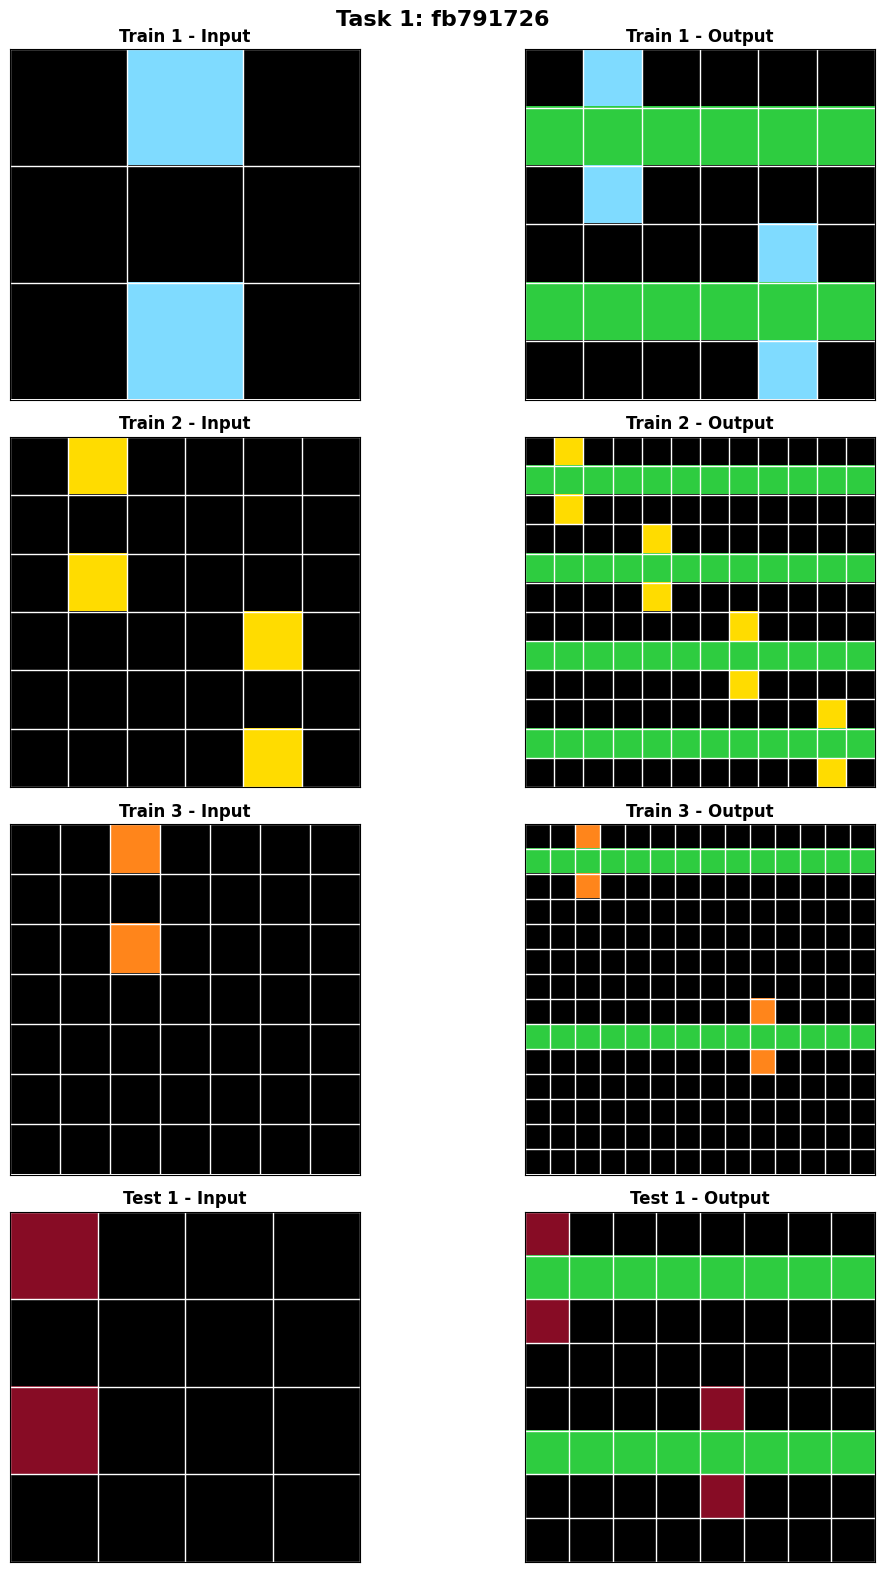



2. Task ID: c8cbb738
   Training pairs: 3
   Test pairs: 1
----------------------------------------


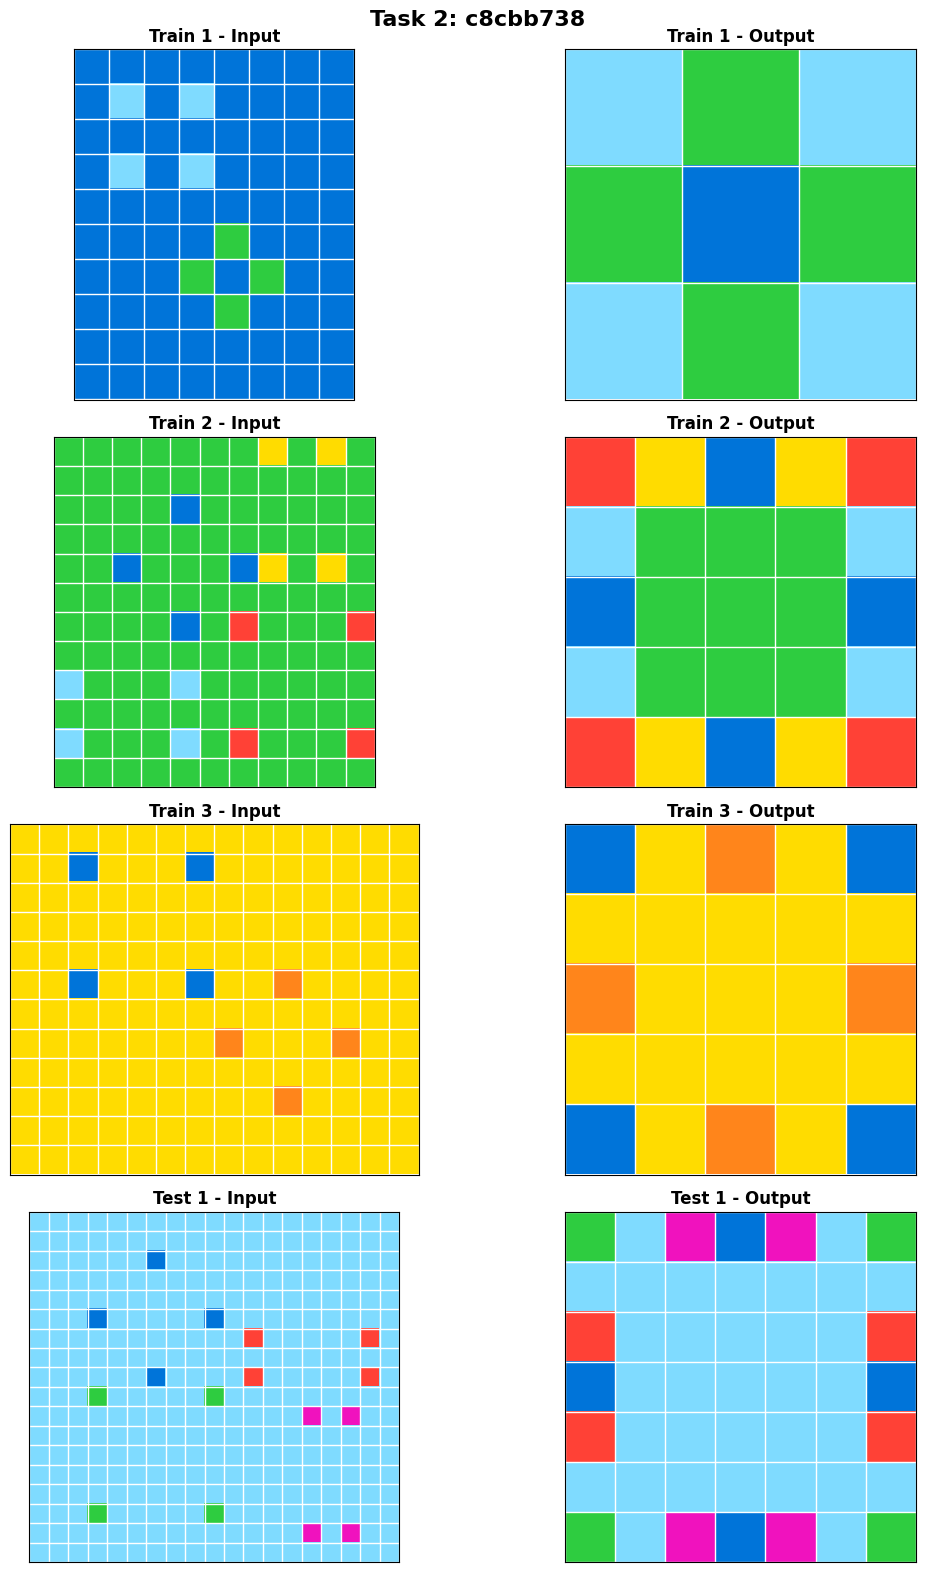



3. Task ID: 782b5218
   Training pairs: 3
   Test pairs: 1
----------------------------------------


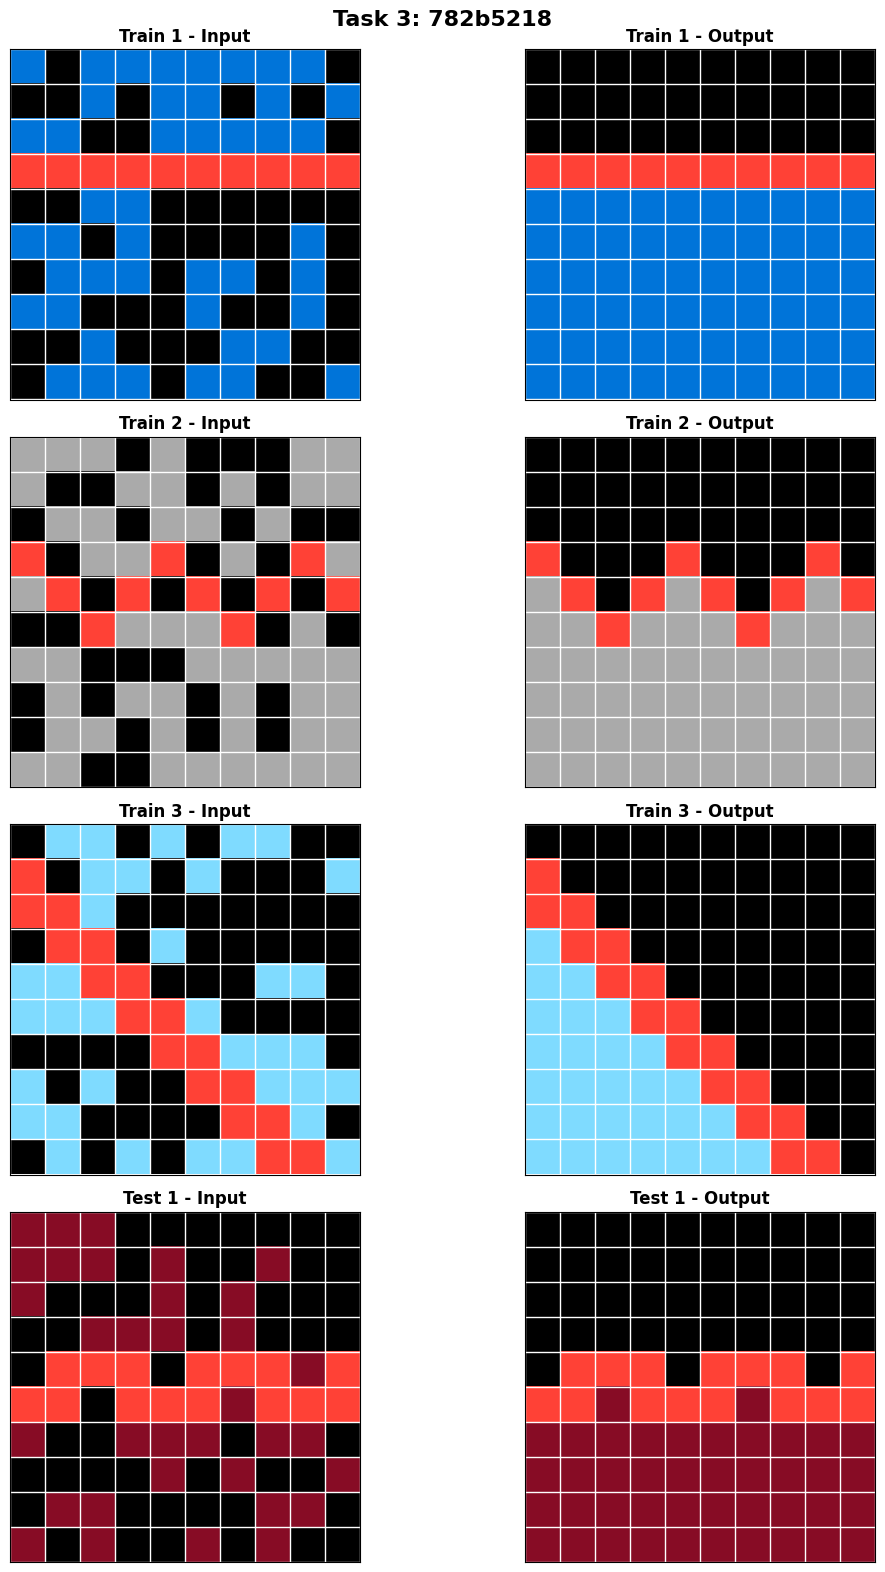

Visualization options available:
1. visualize_task_from_data(data, 'task_id', max_pairs=N) - specific task from loaded data
2. visualize_all_tasks_in_data(data, show_all_pairs=True) - all tasks in data dict
3. quick_random_visualization('path/to/file.txt', num_tasks=N) - load and show random tasks
4. load_random_tasks('path/to/file.txt', N) - load N random tasks into data dict

To run examples, uncomment the code above and execute the cell.


In [8]:
# Visualization Examples - Uncomment to use

# Option 1: Visualize a specific task from loaded data
# if training_data:
#     first_task_id = list(training_data.keys())[0]
#     visualize_task_from_data(training_data, first_task_id, max_pairs=2)

# Option 2: Visualize all tasks in random subset
if random_training_data:
    visualize_all_tasks_in_data(random_training_data, show_all_pairs=True)

# Option 3: Quick random visualization (loads and shows in one step)
# quick_random_visualization('data/raw/arc/training.txt', num_tasks=3)

# Option 4: Load and visualize random evaluation tasks
# random_eval_data = load_random_tasks('data/raw/arc/evaluation.txt', num_tasks=2)
# if random_eval_data:
#     visualize_all_tasks_in_data(random_eval_data, show_all_pairs=False, max_pairs=2)

print("Visualization options available:")
print("1. visualize_task_from_data(data, 'task_id', max_pairs=N) - specific task from loaded data")
print("2. visualize_all_tasks_in_data(data, show_all_pairs=True) - all tasks in data dict")
print("3. quick_random_visualization('path/to/file.txt', num_tasks=N) - load and show random tasks")
print("4. load_random_tasks('path/to/file.txt', N) - load N random tasks into data dict")
print("\nTo run examples, uncomment the code above and execute the cell.")

In [9]:
# Load evaluation data for comparison
# eval_data = load_arc_data('data/raw/arc/evaluation.txt')

# if eval_data:
#     print(f"Successfully loaded {len(eval_data)} evaluation tasks")

#     # Show some example task IDs
#     sample_eval_ids = list(eval_data.keys())[:3]
#     print(f"Sample evaluation task IDs: {sample_eval_ids}")

#     # Compare with training data
#     if training_data:
#         print(f"Dataset Comparison:")
#         print(f"   Training tasks: {len(training_data)}")
#         print(f"   Evaluation tasks: {len(eval_data)}")

#         # Check for any overlap (should be none)
#         overlap = set(training_data.keys()) & set(eval_data.keys())
#         if overlap:
#             print(f"   Overlap found: {len(overlap)} tasks")
#         else:
#             print(f"   No overlap - clean data split")
# else:
#     print("Failed to load evaluation data")

# print("\n" + "="*50)

# Example: Load random evaluation tasks
print("Loading RANDOM SUBSET of evaluation data...")
random_eval_data = load_random_tasks('data/raw/arc/evaluation.txt', num_tasks=3)

if random_eval_data:
    print(f"Successfully loaded {len(random_eval_data)} random evaluation tasks")
    print(f"Random evaluation task IDs: {list(random_eval_data.keys())}")
else:
    print("Failed to load random evaluation data")

Loading RANDOM SUBSET of evaluation data...
Randomly selected 3 tasks from 120 available
Successfully loaded 3 JSON files
Successfully loaded 3 random evaluation tasks
Random evaluation task IDs: ['7b5033c1', '6e4f6532', '9bbf930d']


Visualizing 3 tasks:

1. Task ID: 7b5033c1
   Training pairs: 2
   Test pairs: 1
----------------------------------------


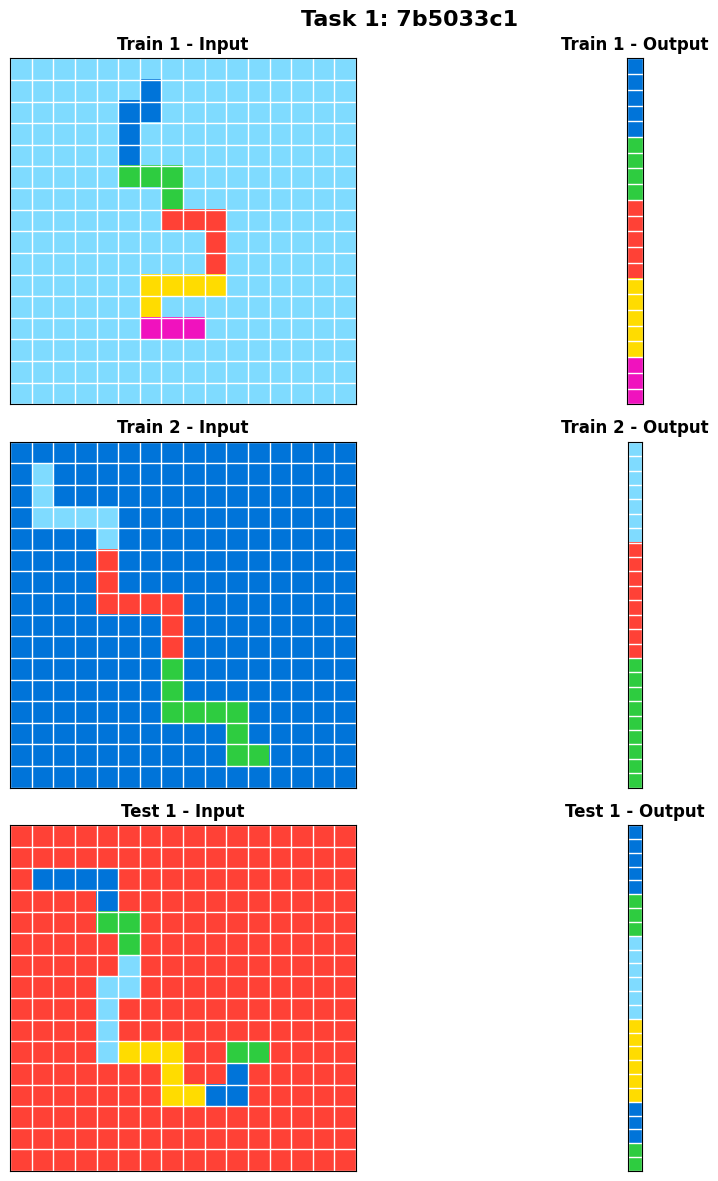



2. Task ID: 6e4f6532
   Training pairs: 2
   Test pairs: 2
----------------------------------------


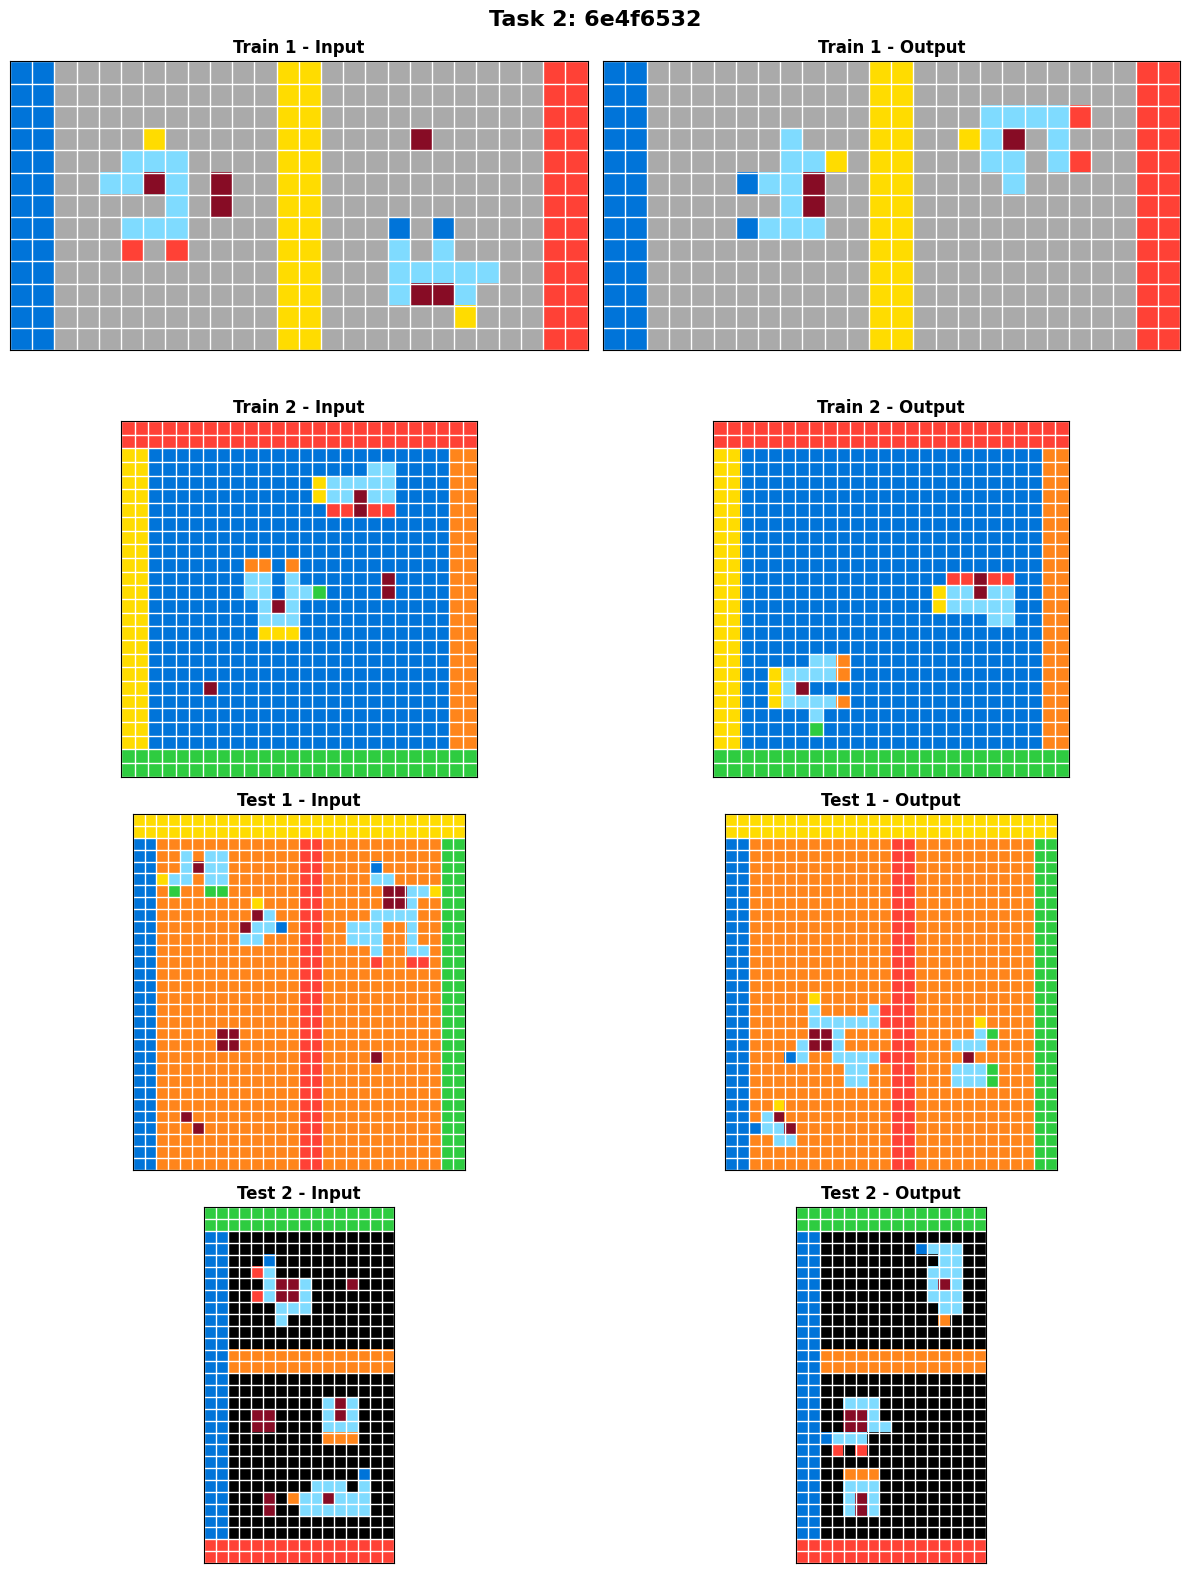



3. Task ID: 9bbf930d
   Training pairs: 3
   Test pairs: 1
----------------------------------------


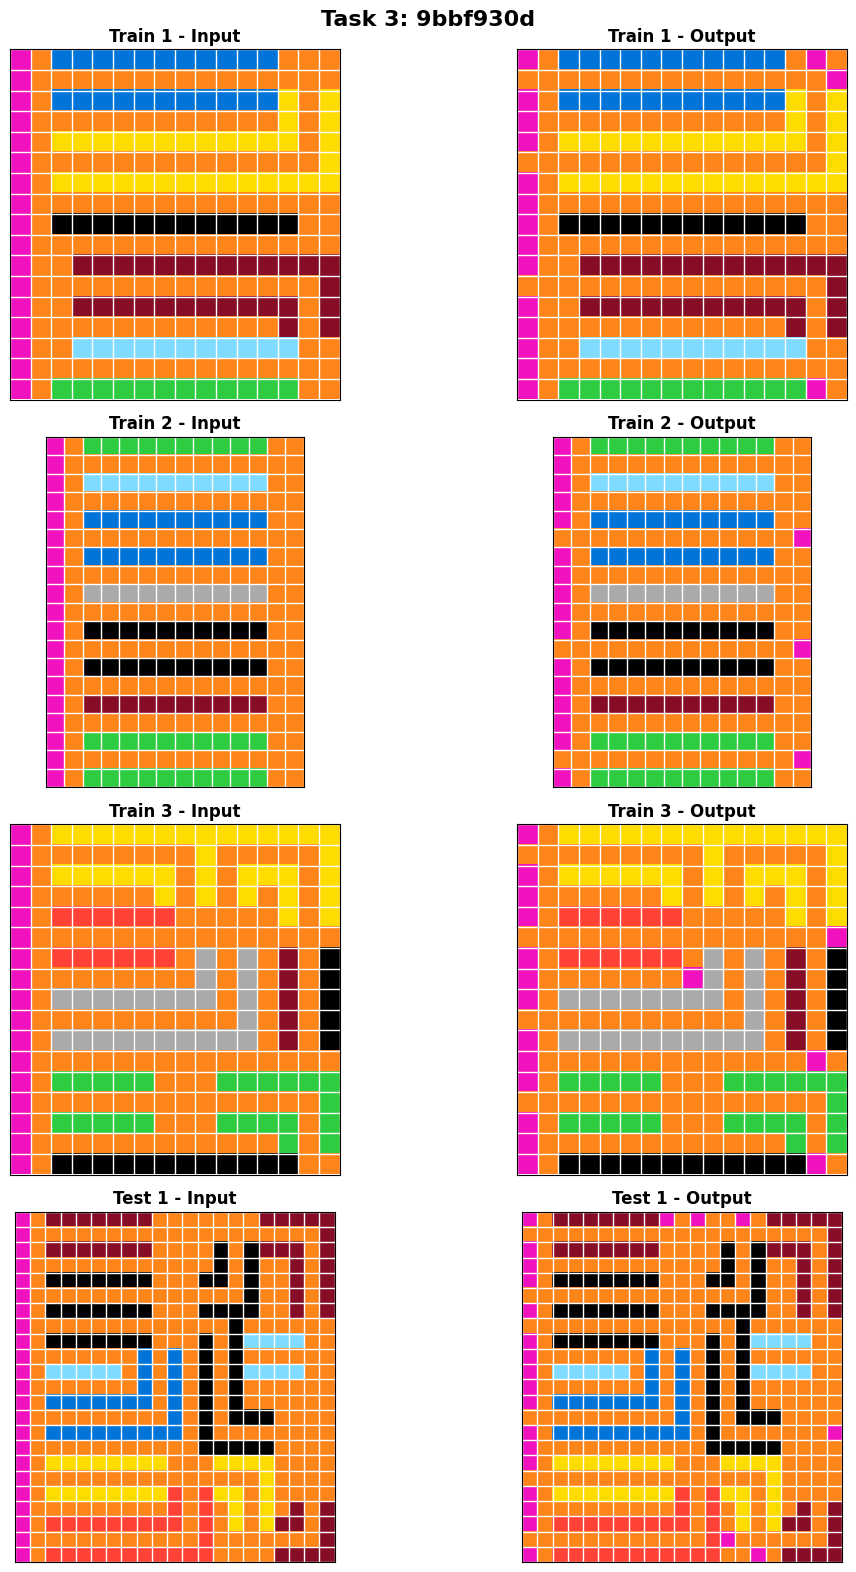

In [10]:
if random_eval_data:
    visualize_all_tasks_in_data(random_eval_data, show_all_pairs=True)

# Data Augmentation Demonstration

This section demonstrates the various data augmentation techniques implemented for ARC-AGI training.

## Augmentation Types Available:

1. **None (Identity)**: No transformation applied
2. **Random**: Mix of geometric transformations + 50% chance of color permutation
3. **Geometric**: All D4 group transformations (rotations, flips, transposes)
4. **Color**: Color palette permutations only
5. **Rotation**: 90°, 180°, 270° rotations
6. **Flip**: Horizontal and vertical flips
7. **Transpose**: Transpose variations

## Augmentation Configuration:

You can control augmentation through a probability dictionary where:
- Keys are augmentation types
- Values are probabilities (automatically normalized)
- Each training example samples one augmentation type based on these probabilities

In [ ]:
# Import augmentation functions from the codebase
import sys
sys.path.insert(0, '..')

from arc.grids.core import Grid
from arc.grids.views import (
    ViewSpec, apply_view_grid, D4, 
    identity_cmap, generate_palette_permutations
)
import numpy as np

# Augmentation Configuration Dictionary
# Modify these values to experiment with different augmentation strategies
AUGMENTATION_CONFIG = {
    'random': 0.0,      # Random mix of geometric + color
    'None': 1.0,        # No augmentation (identity)
    'specific': {
        'geometric': 0.0,   # All geometric transforms
        'color': 0.0,       # Color permutations
        'rotation': 0.0,    # Rotation only (90, 180, 270)
        'flip': 0.0,        # Flip only (horizontal, vertical)
        'transpose': 0.0,   # Transpose variations
    }
}

# Copy the augmentation functions from train.py
def get_random_augmentation(palette, augmentation_type='random', seed=None):
    """Get a random augmentation ViewSpec based on the specified type."""
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    # Default palette if not provided
    if palette is None:
        palette = set(range(10))
    
    # Choose augmentation based on type
    if augmentation_type == 'identity':
        geom = 'id'
        color_map = identity_cmap()
    
    elif augmentation_type == 'geometric':
        geom = random.choice(D4)
        color_map = identity_cmap()
    
    elif augmentation_type == 'rotation':
        geom = random.choice(['rot90', 'rot180', 'rot270'])
        color_map = identity_cmap()
    
    elif augmentation_type == 'flip':
        geom = random.choice(['flip_h', 'flip_v'])
        color_map = identity_cmap()
    
    elif augmentation_type == 'transpose':
        geom = random.choice(['transpose', 'transpose_flip', 'flip_transpose'])
        color_map = identity_cmap()
    
    elif augmentation_type == 'color':
        geom = 'id'
        color_maps = generate_palette_permutations(palette, max_count=8)
        color_map = random.choice(color_maps) if len(color_maps) > 1 else identity_cmap()
    
    elif augmentation_type == 'random':
        geom = random.choice(D4)
        color_map = identity_cmap()
        
        # 50% chance to also apply color permutation
        if random.random() < 0.5:
            color_maps = generate_palette_permutations(palette, max_count=8)
            if len(color_maps) > 1:
                color_map = random.choice(color_maps)
    
    else:
        raise ValueError(f"Unknown augmentation type: {augmentation_type}")
    
    return ViewSpec(geom=geom, color_map=color_map, serialization='row')


def apply_augmentation_to_grids(input_grid, output_grid, augmentation_type='random'):
    """Apply augmentation to a single input-output pair."""
    # Extract palette from both grids
    palette = set(np.unique(input_grid)) | set(np.unique(output_grid))
    
    # Convert to Grid objects
    input_grid_obj = Grid(np.array(input_grid, dtype=np.int8))
    output_grid_obj = Grid(np.array(output_grid, dtype=np.int8))
    
    # Get random augmentation
    view_spec = get_random_augmentation(palette, augmentation_type)
    
    # Apply same augmentation to both input and output
    aug_input = apply_view_grid(input_grid_obj, view_spec)
    aug_output = apply_view_grid(output_grid_obj, view_spec)
    
    return aug_input.a, aug_output.a, view_spec


print("Augmentation functions loaded successfully!")
print("\nAUGMENTATION_CONFIG available for experimentation")
print("Modify the dictionary above to test different augmentation strategies")

In [ ]:
def visualize_augmentation_comparison(input_grid, output_grid, augmentation_type='random', num_samples=3):
    """
    Visualize original vs augmented input-output pairs
    
    Args:
        input_grid: Input grid (2D array)
        output_grid: Output grid (2D array)
        augmentation_type: Type of augmentation to apply
        num_samples: Number of augmented versions to show
    """
    # Create figure with enough subplots
    # Row 1: Original input | Original output
    # Row 2+: Augmented input | Augmented output (for each sample)
    total_rows = 1 + num_samples
    fig, axes = plt.subplots(total_rows, 2, figsize=(12, 4 * total_rows))
    
    # Plot original grids
    plot_grid(input_grid, "Original Input", axes[0, 0])
    plot_grid(output_grid, "Original Output", axes[0, 1])
    
    # Apply and plot augmented versions
    for i in range(num_samples):
        aug_input, aug_output, view_spec = apply_augmentation_to_grids(
            input_grid, output_grid, augmentation_type
        )
        
        # Create descriptive title with transformation details
        geom_desc = view_spec.geom
        color_desc = "color_perm" if view_spec.color_map != identity_cmap() else "no_color"
        aug_desc = f"{augmentation_type.upper()}: {geom_desc} + {color_desc}"
        
        plot_grid(aug_input, f"Augmented Input #{i+1}\n{aug_desc}", axes[i+1, 0])
        plot_grid(aug_output, f"Augmented Output #{i+1}\n{aug_desc}", axes[i+1, 1])
    
    plt.suptitle(f"Augmentation Type: {augmentation_type}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


def demonstrate_all_augmentations(input_grid, output_grid):
    """Demonstrate all augmentation types on a single input-output pair."""
    augmentation_types = ['identity', 'geometric', 'color', 'rotation', 'flip', 'transpose', 'random']
    
    print("="*80)
    print("DEMONSTRATING ALL AUGMENTATION TYPES")
    print("="*80)
    
    for aug_type in augmentation_types:
        print(f"\n{aug_type.upper()} Augmentation:")
        print("-" * 60)
        visualize_augmentation_comparison(input_grid, output_grid, aug_type, num_samples=2)


def demonstrate_augmentation_configs(input_grid, output_grid, num_examples=5):
    """
    Demonstrate different augmentation configuration scenarios.
    
    Shows how the probability distribution affects which augmentations are applied.
    """
    configs = [
        {
            'name': '100% No Augmentation',
            'config': {
                'random': 0.0,
                'None': 1.0,
                'specific': {'geometric': 0.0, 'color': 0.0, 'rotation': 0.0, 'flip': 0.0, 'transpose': 0.0}
            }
        },
        {
            'name': '50% Random, 50% None',
            'config': {
                'random': 0.5,
                'None': 0.5,
                'specific': {'geometric': 0.0, 'color': 0.0, 'rotation': 0.0, 'flip': 0.0, 'transpose': 0.0}
            }
        },
        {
            'name': 'Mix: 30% Geometric, 40% Color, 30% None',
            'config': {
                'random': 0.0,
                'None': 0.3,
                'specific': {'geometric': 0.3, 'color': 0.4, 'rotation': 0.0, 'flip': 0.0, 'transpose': 0.0}
            }
        },
        {
            'name': 'Geometric Only (80% geometric, 20% none)',
            'config': {
                'random': 0.0,
                'None': 0.2,
                'specific': {'geometric': 0.8, 'color': 0.0, 'rotation': 0.0, 'flip': 0.0, 'transpose': 0.0}
            }
        },
        {
            'name': 'Balanced Mix of All',
            'config': {
                'random': 0.2,
                'None': 0.2,
                'specific': {'geometric': 0.2, 'color': 0.2, 'rotation': 0.1, 'flip': 0.1, 'transpose': 0.0}
            }
        }
    ]
    
    for config_info in configs:
        print("\n" + "="*80)
        print(f"Configuration: {config_info['name']}")
        print("="*80)
        print(f"Config: {config_info['config']}")
        print("-" * 80)
        
        # Sample augmentation types based on probability distribution
        aug_config = config_info['config']
        
        # Build probability distribution
        choices = []
        probs = []
        
        if aug_config.get('random', 0) > 0:
            choices.append('random')
            probs.append(aug_config['random'])
        
        if aug_config.get('None', 0) > 0:
            choices.append('identity')
            probs.append(aug_config['None'])
        
        specific = aug_config.get('specific', {})
        for aug_type, prob in specific.items():
            if prob > 0:
                choices.append(aug_type)
                probs.append(prob)
        
        # Normalize probabilities
        total = sum(probs)
        if total > 0:
            probs = [p / total for p in probs]
        
        # Sample and show examples
        fig, axes = plt.subplots(num_examples, 2, figsize=(12, 4 * num_examples))
        
        if num_examples == 1:
            axes = axes.reshape(1, -1)
        
        for i in range(num_examples):
            # Sample augmentation type
            aug_type = np.random.choice(choices, p=probs)
            
            # Apply augmentation
            aug_input, aug_output, view_spec = apply_augmentation_to_grids(
                input_grid, output_grid, aug_type
            )
            
            # Create description
            geom_desc = view_spec.geom
            color_desc = "color_perm" if view_spec.color_map != identity_cmap() else "no_color"
            aug_desc = f"{aug_type}: {geom_desc} + {color_desc}"
            
            plot_grid(aug_input, f"Example #{i+1} Input\n{aug_desc}", axes[i, 0])
            plot_grid(aug_output, f"Example #{i+1} Output\n{aug_desc}", axes[i, 1])
        
        plt.suptitle(f"{config_info['name']}", fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print(f"Showing {num_examples} sampled examples from this configuration\n")


print("Visualization functions defined!")
print("\nAvailable functions:")
print("  visualize_augmentation_comparison(input, output, 'augmentation_type', num_samples=3)")
print("  demonstrate_all_augmentations(input, output)")
print("  demonstrate_augmentation_configs(input, output, num_examples=5)")

## Load Sample Task for Demonstration

Let's load a sample task from the training data to demonstrate the augmentations.

In [ ]:
# Load a sample training task
import json
import os

# Path to training data
train_dir = "../data/raw/arc/training"
train_files = [f for f in os.listdir(train_dir) if f.endswith('.json')]

# Load first training task
sample_file = os.path.join(train_dir, train_files[0])
with open(sample_file, 'r') as f:
    task_data = json.load(f)

print(f"Loaded task: {train_files[0]}")
print(f"Number of training examples: {len(task_data['train'])}")
print(f"Number of test examples: {len(task_data['test'])}")

# Get first training example
sample_example = task_data['train'][0]
sample_input = np.array(sample_example['input'])
sample_output = np.array(sample_example['output'])

print(f"\nInput shape: {sample_input.shape}")
print(f"Output shape: {sample_output.shape}")

# Visualize the original example
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_grid(sample_input, "Original Input", axes[0])
plot_grid(sample_output, "Original Output", axes[1])
plt.suptitle(f"Original Task Example from {train_files[0]}", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Demonstration 1: Individual Augmentation Types

This section shows each augmentation type separately with 2 examples each to highlight what transformations are applied.

In [ ]:
# Demonstrate all augmentation types
demonstrate_all_augmentations(sample_input, sample_output)

## Demonstration 2: Multiple Augmentation Configuration Scenarios

This section demonstrates different probability configurations and shows how they affect which augmentations are applied. Each configuration is sampled 5 times to show the variety of augmentations that can be applied based on the probability distribution.

In [ ]:
# Demonstrate different augmentation configurations
demonstrate_augmentation_configs(sample_input, sample_output, num_examples=5)

## Demonstration 3: Custom Configuration Testing

Use the `AUGMENTATION_CONFIG` dictionary defined earlier to experiment with your own configurations. Modify the dictionary and run the cell below to see the results.

**Example configurations to try:**
```python
# Only geometric transformations
AUGMENTATION_CONFIG = {
    'random': 0.0,
    'None': 0.0,
    'specific': {
        'geometric': 1.0,
        'color': 0.0,
        'rotation': 0.0,
        'flip': 0.0,
        'transpose': 0.0
    }
}

# Mix of rotations and flips
AUGMENTATION_CONFIG = {
    'random': 0.0,
    'None': 0.2,
    'specific': {
        'geometric': 0.0,
        'color': 0.0,
        'rotation': 0.4,
        'flip': 0.4,
        'transpose': 0.0
    }
}

# Heavy augmentation
AUGMENTATION_CONFIG = {
    'random': 0.3,
    'None': 0.0,
    'specific': {
        'geometric': 0.2,
        'color': 0.2,
        'rotation': 0.1,
        'flip': 0.1,
        'transpose': 0.1
    }
}
```

In [ ]:
# Use your custom AUGMENTATION_CONFIG to test different scenarios
# Modify the AUGMENTATION_CONFIG dictionary in the earlier cell and run this

# Build probability distribution from config
choices = []
probs = []

if AUGMENTATION_CONFIG.get('random', 0) > 0:
    choices.append('random')
    probs.append(AUGMENTATION_CONFIG['random'])

if AUGMENTATION_CONFIG.get('None', 0) > 0:
    choices.append('identity')
    probs.append(AUGMENTATION_CONFIG['None'])

specific = AUGMENTATION_CONFIG.get('specific', {})
for aug_type, prob in specific.items():
    if prob > 0:
        choices.append(aug_type)
        probs.append(prob)

# Normalize probabilities
total = sum(probs)
if total > 0:
    probs = [p / total for p in probs]

print("Current Configuration:")
print(f"  Random: {AUGMENTATION_CONFIG.get('random', 0)}")
print(f"  None: {AUGMENTATION_CONFIG.get('None', 0)}")
print(f"  Specific augmentations: {AUGMENTATION_CONFIG.get('specific', {})}")
print(f"\nNormalized probability distribution:")
for choice, prob in zip(choices, probs):
    print(f"  {choice}: {prob:.2%}")

# Generate and visualize samples
print("\n" + "="*80)
print("Generating 6 samples from your custom configuration")
print("="*80)

fig, axes = plt.subplots(6, 2, figsize=(12, 24))

for i in range(6):
    # Sample augmentation type
    aug_type = np.random.choice(choices, p=probs)
    
    # Apply augmentation
    aug_input, aug_output, view_spec = apply_augmentation_to_grids(
        sample_input, sample_output, aug_type
    )
    
    # Create description
    geom_desc = view_spec.geom
    color_desc = "color_perm" if view_spec.color_map != identity_cmap() else "no_color"
    aug_desc = f"{aug_type}: {geom_desc} + {color_desc}"
    
    plot_grid(aug_input, f"Sample #{i+1} Input\n{aug_desc}", axes[i, 0])
    plot_grid(aug_output, f"Sample #{i+1} Output\n{aug_desc}", axes[i, 1])

plt.suptitle("Custom Configuration Results", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Quick Start Guide

1. **Setup**: Run the first two cells to install dependencies and import libraries
2. **Load Data**: Execute the data loading cells to see available tasks
3. **Browse**: Use `browse_tasks(data, start_idx=0, num_tasks=10)` to see task IDs
4. **Visualize**: Choose from multiple visualization options below
5. **Explore**: Try different parameters to understand various puzzle patterns

## Visualization Options

### Random Task Selection (NEW!)
- `visualize_random_sample()`: Quick way to see 3 random tasks from loaded data
- `visualize_random_tasks(data, num_tasks=3, show_all_pairs=True)`: Custom random selection

### Specific Task Selection
- `visualize_task_pairs(data, 'task_id', max_pairs=3)`: Show specific task with limited pairs
- `browse_tasks(data, start_idx=0, num_tasks=10)`: List available task IDs

## Key Functions

- `load_arc_data(path)`: Load training or evaluation data
- `browse_tasks(data, start_idx, num_tasks)`: List available tasks with IDs
- `visualize_task_pairs(data, task_id, max_pairs)`: Show input/output pairs for specific task
- `visualize_random_tasks(data, num_tasks, show_all_pairs)`: Show random tasks with all/limited pairs
- `visualize_random_sample()`: Quick random selection from loaded data
- `plot_grid(grid, title)`: Plot individual grid with proper colors

## Parameters Explained

- `max_pairs`: Limits pairs shown per task (for specific task visualization)
- `num_tasks`: Number of tasks to display (for browsing or random selection)
- `show_all_pairs`: If True, shows ALL pairs in selected tasks; if False, limits to 3 pairs
- `start_idx`: Starting position for browsing tasks

## Tips

- Each task has multiple training pairs and test pairs
- Grids use colors 0-9 mapped to distinct colors
- Input/Output pairs show the transformation pattern to learn
- Random selection helps discover diverse puzzle types
- Use `show_all_pairs=False` for large tasks to avoid overwhelming displays